In [34]:
#Step 0 Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import  GridSearchCV
from sklearn.inspection import permutation_importance

In [2]:
#Step 1 import data
df_raw = pd.read_csv("../data/hour.csv")
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     17379 non-null  int64  
 1   dteday      17379 non-null  object 
 2   season      17379 non-null  int64  
 3   yr          17379 non-null  int64  
 4   mnth        17379 non-null  int64  
 5   hr          17379 non-null  int64  
 6   holiday     17379 non-null  int64  
 7   weekday     17379 non-null  int64  
 8   workingday  17379 non-null  int64  
 9   weathersit  17379 non-null  int64  
 10  temp        17379 non-null  float64
 11  atemp       17379 non-null  float64
 12  hum         17379 non-null  float64
 13  windspeed   17379 non-null  float64
 14  casual      17379 non-null  int64  
 15  registered  17379 non-null  int64  
 16  cnt         17379 non-null  int64  
dtypes: float64(4), int64(12), object(1)
memory usage: 2.3+ MB


In [3]:
#Step 2: Preprocessing
df_baking = df_raw.copy()
df_baking['cnt_lagged_week']= df_baking['cnt'].shift(24*7)
df_baking['season'] = df_baking['season'].map({1:"invierno", 2:"primavera", 3:"verano", 4:"otoño"})
df_baking['season'] = df_baking['season'].replace(['invierno','otoño','primavera','verano'],[0,1,2,3])
df_baking['yr'] = df_baking['yr'].map({0:2011, 1:2012})
df_baking['yr'] = df_baking['yr'].astype('category')
df_baking['mnth'] = df_baking['mnth'].astype('category')
df_baking['weekday'] = df_baking['weekday'].map({0:"D", 1:"L",2:"Ma",3:"Mi",4:"J",5:"V",6:"S"})
df_baking['weekday'] = df_baking['weekday'].replace(['L','Ma','Mi','J','V','S','D'],[0,1,2,3,4,5,6])
df_baking['weathersit'] = df_baking['weathersit'].astype('category')
df_baking['temp'] = df_baking['temp'].map(lambda x: x*47-8)
df_baking['atemp'] = df_baking['atemp'].map(lambda x: x*66-16)
df_baking['hum'] = df_baking['hum'].map(lambda x: x*100)
df_baking['windspeed'] = df_baking['windspeed'].map(lambda x: x*67)
df_baking['holiday'] = df_baking['holiday'].map({0:"No", 1:"Si"})
df_baking['holiday'] = df_baking['holiday'].astype('category')
df_baking['workingday'] = df_baking['workingday'].map({0:"No", 1:"Si"})
df_baking['workingday'] = df_baking['workingday'].astype('category')
df_baking['dteday'] = pd.to_datetime(df_baking['dteday'], errors='coerce')
df_baking['hr'] = pd.to_numeric(df_baking['hr'], errors='coerce').astype('Int64')
df_baking['datetime'] = df_baking['dteday'] + pd.to_timedelta(df_baking['hr'], unit='h')
df_baking = df_baking.sort_values('datetime').set_index('datetime').asfreq('H')
df_baking = df_baking.drop(columns=['instant', 'dteday', 'yr','mnth'])
df_baking = df_baking.dropna()
df = df_baking.copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17211 entries, 2011-01-08 07:00:00 to 2012-12-31 23:00:00
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   season           17211 non-null  float64 
 1   hr               17211 non-null  Int64   
 2   holiday          17211 non-null  category
 3   weekday          17211 non-null  float64 
 4   workingday       17211 non-null  category
 5   weathersit       17211 non-null  category
 6   temp             17211 non-null  float64 
 7   atemp            17211 non-null  float64 
 8   hum              17211 non-null  float64 
 9   windspeed        17211 non-null  float64 
 10  casual           17211 non-null  float64 
 11  registered       17211 non-null  float64 
 12  cnt              17211 non-null  float64 
 13  cnt_lagged_week  17211 non-null  float64 
dtypes: Int64(1), category(3), float64(10)
memory usage: 1.6 MB


/tmp/ipykernel_3225/1764059159.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_baking['season'] = df_baking['season'].replace(['invierno','otoño','primavera','verano'],[0,1,2,3])
/tmp/ipykernel_3225/1764059159.py:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_baking['weekday'] = df_baking['weekday'].replace(['L','Ma','Mi','J','V','S','D'],[0,1,2,3,4,5,6])
/tmp/ipykernel_3225/1764059159.py:23: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_baking = df_baking.sort_

In [4]:
df.sample(10, random_state= 2025)

,season,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,cnt_lagged_week
datetime,,,,,,,,,,,,,,
2012-10-15 05:00:00,1.0,5,No,0.0,Si,2,18.32,18.9998,73.0,19.0012,2.0,38.0,40.0,19.0
2011-05-12 15:00:00,2.0,15,No,3.0,Si,2,22.08,24.9992,53.0,16.9979,54.0,163.0,217.0,147.0
2011-04-27 09:00:00,2.0,9,No,2.0,Si,2,20.20,20.0030,88.0,27.9993,20.0,161.0,181.0,197.0
2012-02-01 15:00:00,0.0,15,No,2.0,Si,1,20.20,24.9992,35.0,19.0012,25.0,169.0,194.0,155.0
2012-08-21 06:00:00,3.0,6,No,1.0,Si,1,18.32,18.9998,83.0,7.0015,5.0,164.0,169.0,64.0
2011-11-25 09:00:00,1.0,9,No,4.0,Si,1,7.04,7.0010,76.0,0.0000,25.0,70.0,95.0,213.0
2011-06-13 13:00:00,2.0,13,No,0.0,Si,1,24.90,26.0024,37.0,0.0000,53.0,174.0,227.0,180.0
2011-07-16 06:00:00,3.0,6,No,5.0,No,1,20.20,22.0028,78.0,11.0014,16.0,21.0,37.0,38.0
2011-03-25 11:00:00,2.0,11,No,4.0,Si,1,6.10,3.0014,45.0,19.0012,17.0,58.0,75.0,210.0


In [5]:
#Step 3: EDA

df_train, df_test = df[:16416], df[16416:]
df_train.tail(1)

,season,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,cnt_lagged_week
datetime,,,,,,,,,,,,,,
2012-11-28 17:00:00,1.0,17,No,2.0,Si,1,7.98,5.9978,31.0,8.9981,17.0,546.0,563.0,374.0


In [6]:
display(df_train.describe(include='number').T.assign(range= lambda x: x['max']- x['min']))
display(df_train.describe(include='category').T)

,count,mean,std,min,25%,50%,75%,max,range
season,16416.0,1.584125,1.120349,0.0,1.0,2.0,3.0,3.0,3.0
hr,16416.0,11.544773,6.913094,0.0,6.0,12.0,18.0,23.0,23.0
weekday,16416.0,3.00664,2.001374,0.0,1.0,3.0,5.0,6.0,6.0
temp,16416.0,15.880272,8.98724,-7.06,7.98,16.44,23.02,39.0,46.06
atemp,16416.0,16.04307,11.260963,-16.0,5.9978,17.0,24.9992,50.0,66.0
hum,16416.0,62.543494,19.34589,0.0,47.0,63.0,78.0,100.0,100.0
windspeed,16416.0,12.779663,8.17573,0.0,7.0015,12.998,16.9979,56.9969,56.9969
casual,16416.0,36.861172,50.206666,0.0,4.0,17.0,50.0,367.0,367.0
registered,16416.0,154.832481,151.514724,0.0,35.0,117.0,221.0,886.0,886.0
cnt,16416.0,191.693653,182.363485,1.0,41.0,145.0,283.0,977.0,976.0


,count,unique,top,freq
holiday,16416,2,No,15939
workingday,16416,2,Si,11219
weathersit,16416,4,1,10926


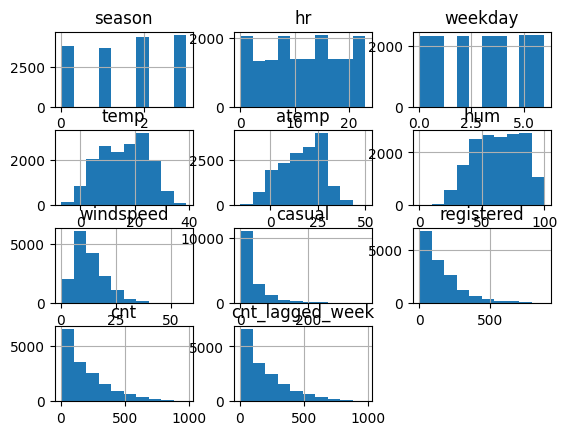

In [7]:
df_train.hist()
plt.show()


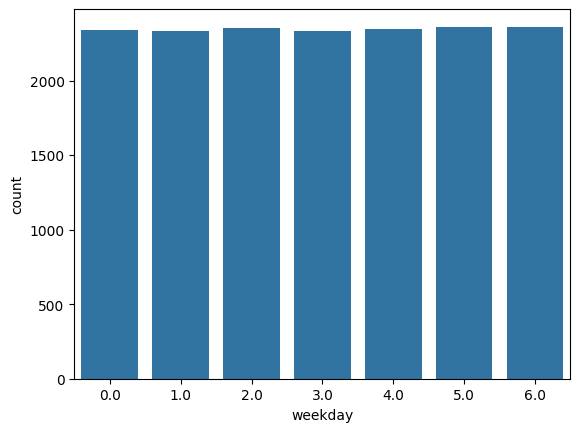

In [8]:
sns.countplot(df_train, x='weekday')
plt.show()

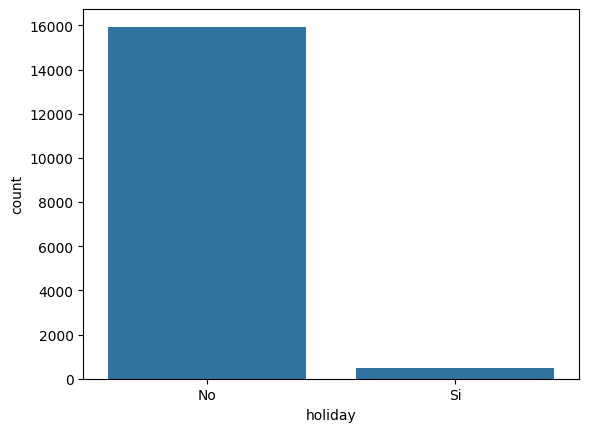

In [9]:
sns.countplot(df_train, x='holiday')
plt.show()

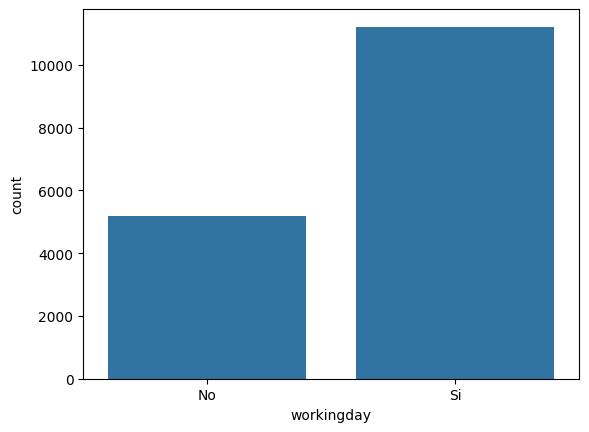

In [10]:
sns.countplot(df_train, x='workingday')
plt.show()

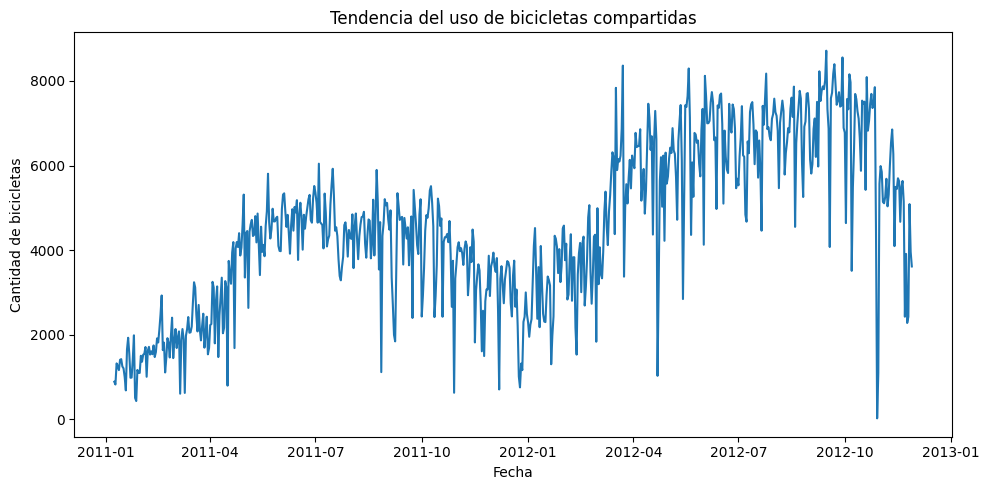

In [11]:
df_daily= df_train['cnt'].resample('D').sum()

plt.figure(figsize=(10,5))
plt.plot(df_daily.index, df_daily.values)
plt.title('Tendencia del uso de bicicletas compartidas')
plt.xlabel('Fecha')
plt.ylabel('Cantidad de bicicletas')
plt.tight_layout()
plt.show()

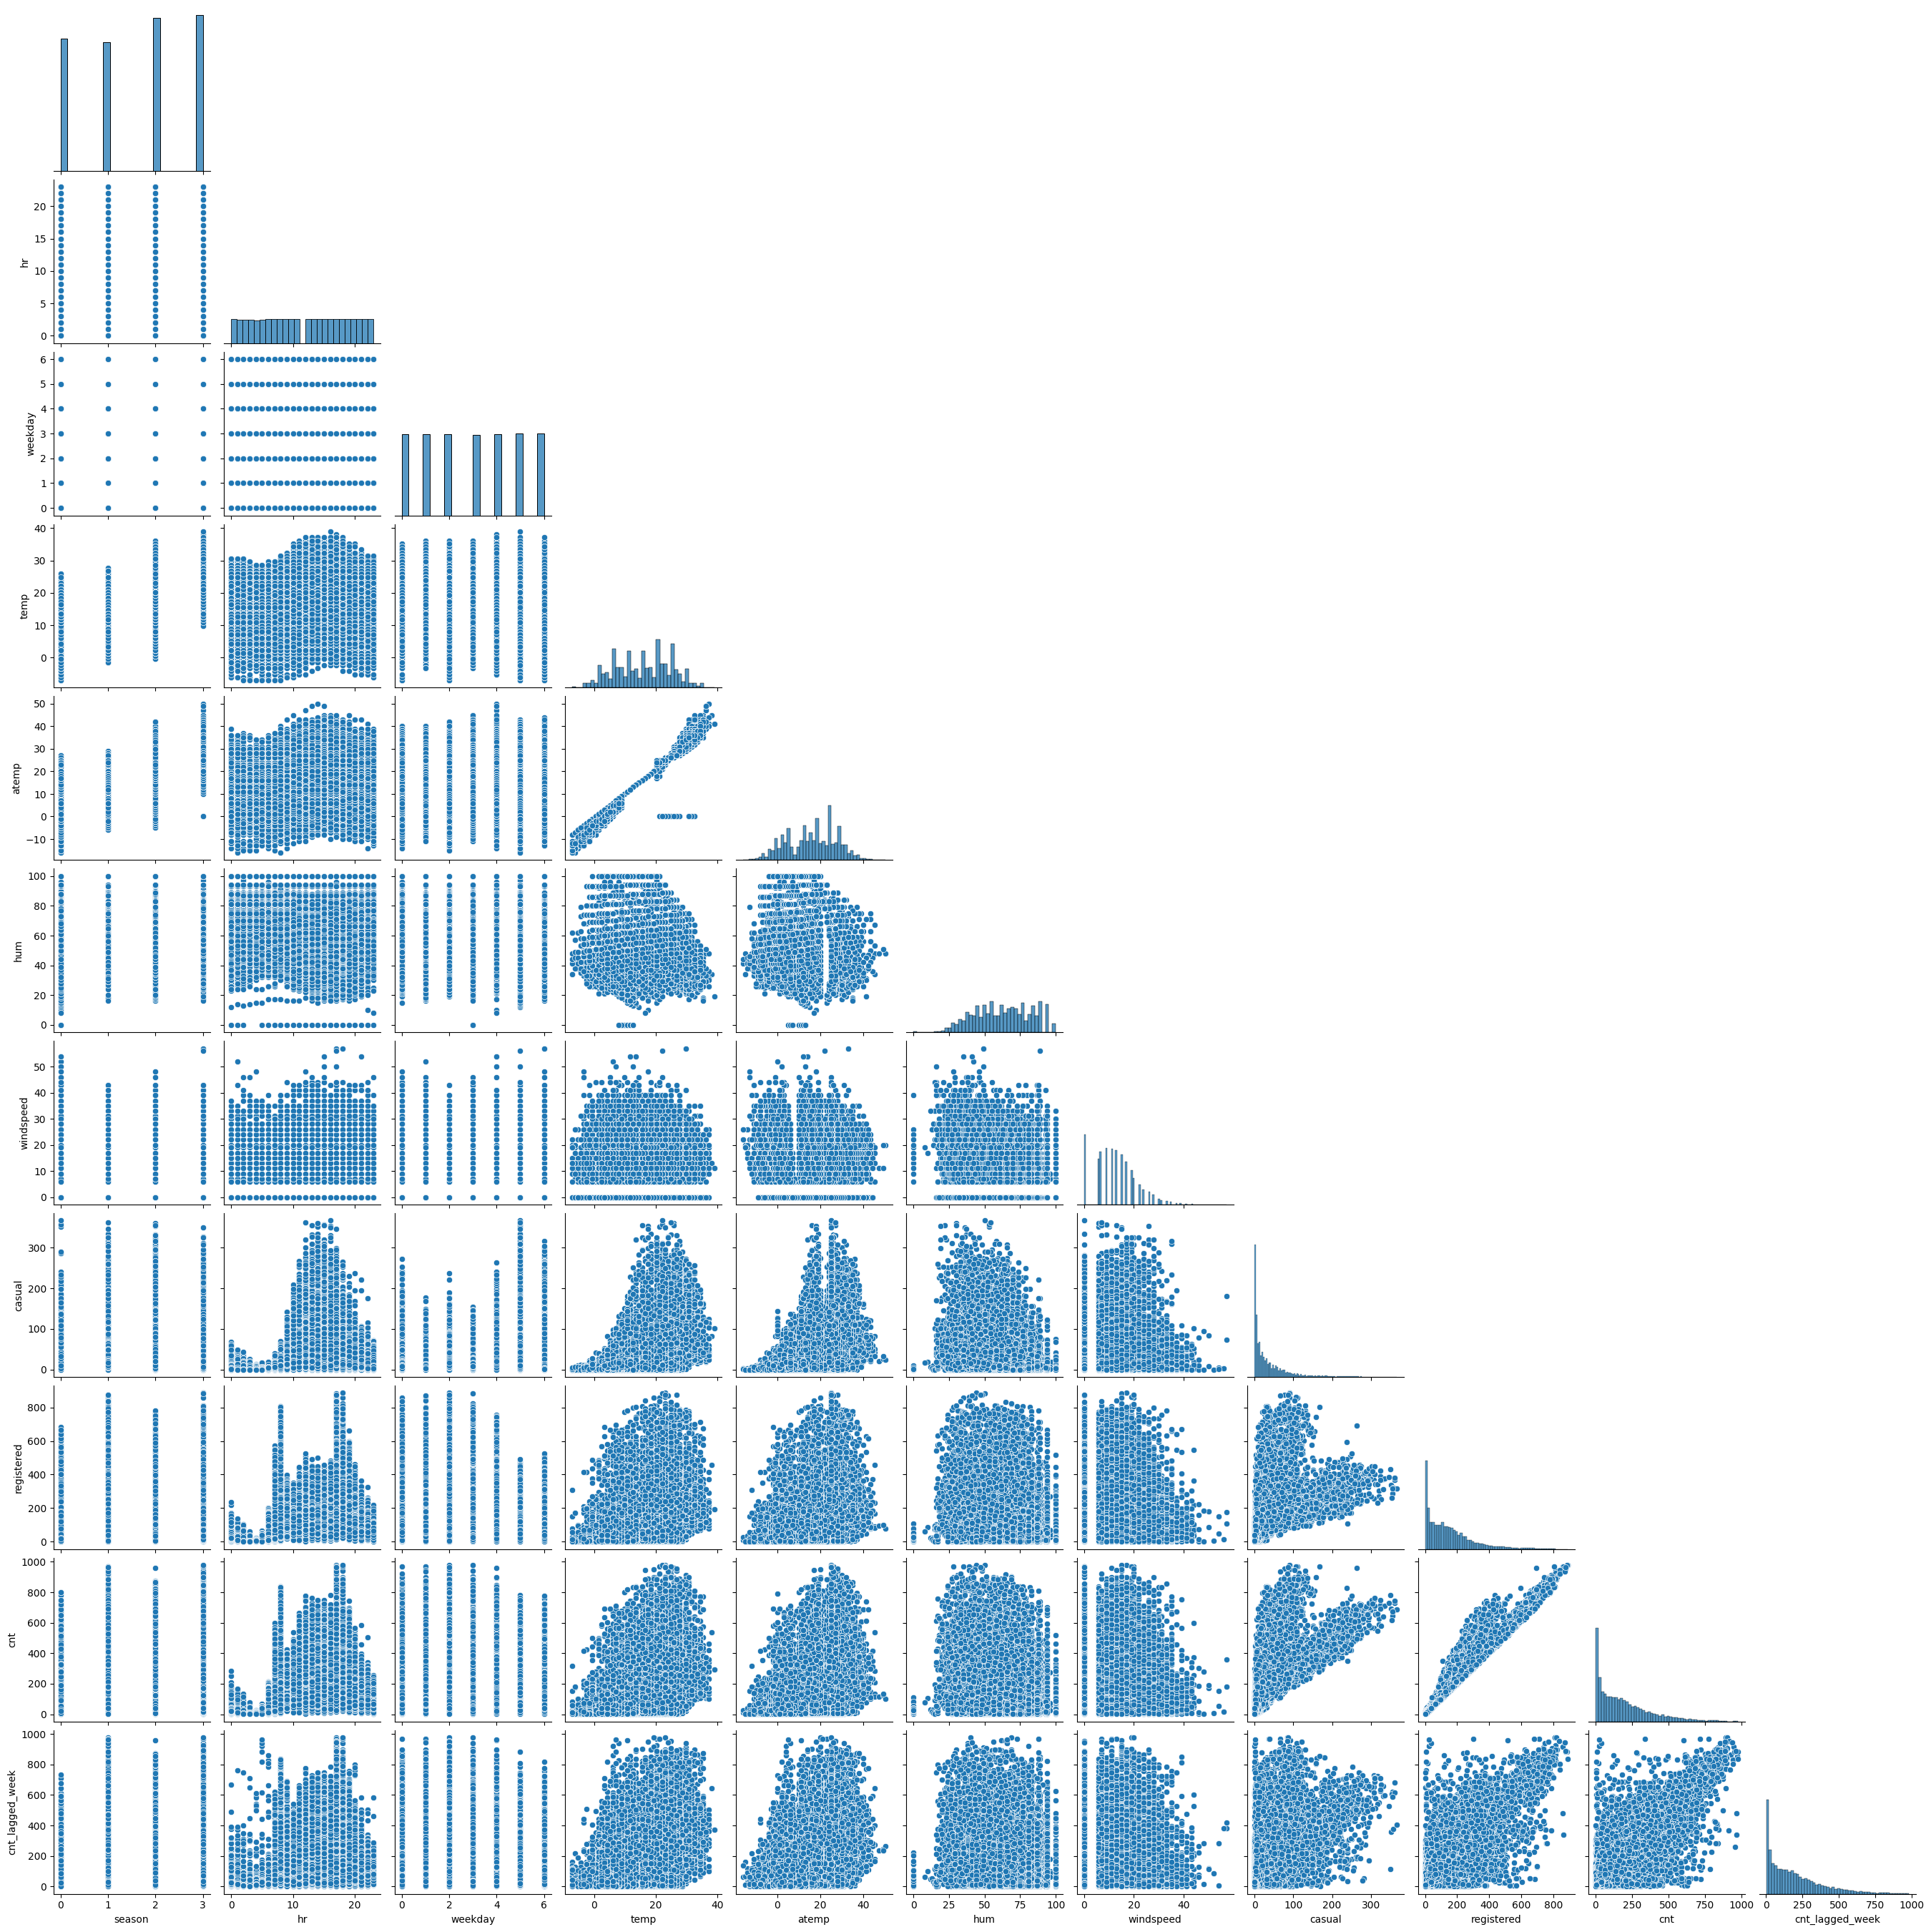

In [12]:
sns.pairplot(df_train, corner=True)
plt.show()

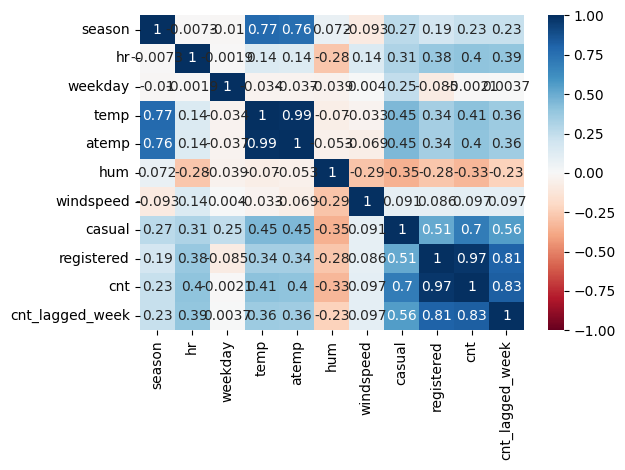

In [13]:
sns.heatmap(df_train.select_dtypes('number').corr(), vmin=-1, vmax=1, annot=True, cmap='RdBu')
plt.tight_layout()
plt.show()

/tmp/ipykernel_3225/2301624307.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 50)` for the same effect.

  sns.barplot(


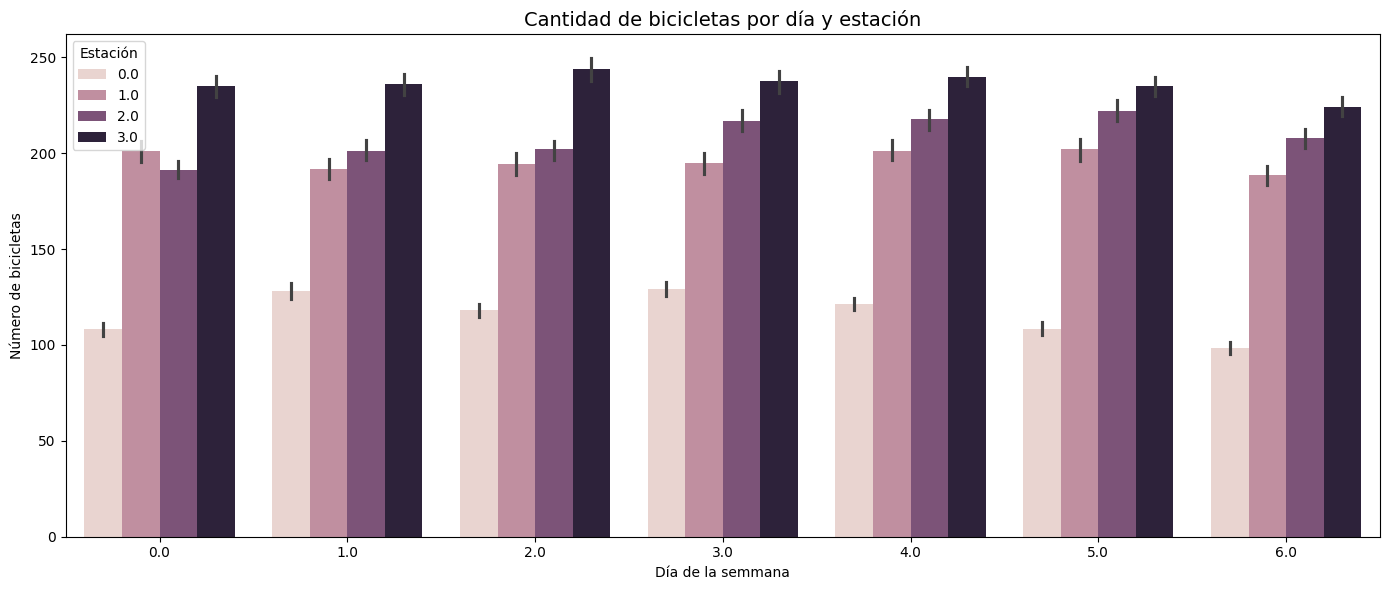

In [14]:
plt.figure(figsize=(14,6))
sns.barplot(
    x="weekday",
    y="cnt",
    hue="season",
    data= df_train,
    ci= 50
)

plt.title("Cantidad de bicicletas por día y estación", fontsize=14)
plt.xlabel("Día de la semmana")
plt.ylabel("Número de bicicletas")
plt.legend(title="Estación")
plt.tight_layout()
plt.show()

/tmp/ipykernel_3225/2545068421.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 50)` for the same effect.

  sns.barplot(


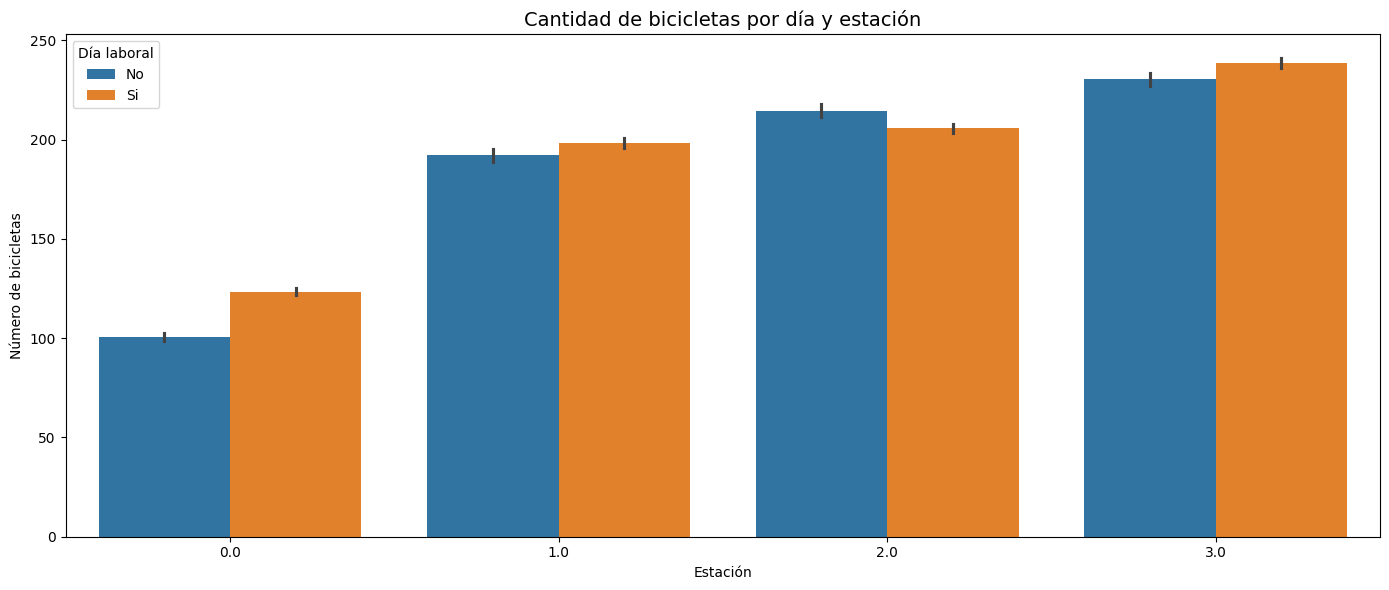

In [15]:
plt.figure(figsize=(14,6))
sns.barplot(
    x="season",
    y="cnt",
    hue="workingday",
    data= df_train,
    ci= 50
)

plt.title("Cantidad de bicicletas por día y estación", fontsize=14)
plt.xlabel("Estación")
plt.ylabel("Número de bicicletas")
plt.legend(title="Día laboral")
plt.tight_layout()
plt.show()

In [16]:
#Machine Learning
target = 'cnt'
X_train = df_train.drop(columns=[target, 'casual', 'registered'])
y_train= df_train[target]
mask_train= y_train.notna()
X_train= X_train[mask_train]
y_train= y_train[mask_train]


X_test= df_test.drop(columns=[target, 'casual', 'registered'])
y_test= df_test[target]
mask_test= y_test.notna()
X_test= X_test[mask_test]
y_test= y_test[mask_test]


In [17]:
num_cols= X_train.select_dtypes('number').columns
cat_cols= X_train.select_dtypes('category').columns

preprocessor = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), num_cols),
        ('cat', OneHotEncoder(drop='first'), cat_cols)
    ]
)

In [18]:
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(
        n_jobs=-1,
        random_state=42
    )
    )
])

In [19]:
pipeline.fit(X_train, y_train)

,steps,"[('preprocessor', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [20]:
y_pred= pipeline.predict(X_test)

mae= mean_absolute_error(y_test, y_pred)
mse= mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R2: {r2:.2f}")

MAE: 53.27
MSE: 7155.85
RMSE: 84.59
R2: 0.74


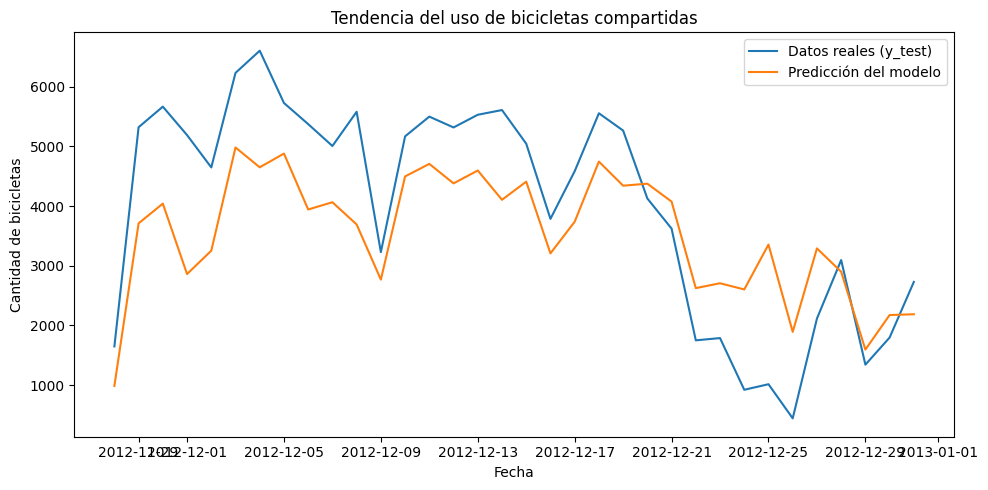

In [21]:
df_daily_test= df_test['cnt'].resample('D').sum()
df_pred = pd.DataFrame(y_pred, index=df_test.index, columns=['cnt'])
df_daily_pred = df_pred['cnt'].resample('D').sum()

plt.figure(figsize=(10,5))
plt.plot(df_daily_test.index, df_daily_test.values, label= 'Datos reales (y_test)')
plt.plot(df_daily_pred.index, df_daily_pred.values, label= 'Predicción del modelo')
plt.title('Tendencia del uso de bicicletas compartidas')
plt.xlabel('Fecha')
plt.ylabel('Cantidad de bicicletas')
plt.legend()
plt.tight_layout()
plt.show()

In [22]:
r_forest_clf_cv = GridSearchCV(
    pipeline,
    param_grid={
        'model__max_depth':[5,6,7,12,15],
        'model__min_samples_split':[4,6,8],
        'model__n_estimators':[100,150,200,250]
    },
    cv = 5
)
#Con este algoritmo buscamos los mejores parametros de tree decision
r_forest_clf_cv.fit(X_train, y_train)
r_forest_clf_cv.best_params_

{'model__max_depth': 12,
 'model__min_samples_split': 8,
 'model__n_estimators': 250}

In [29]:
model = Pipeline(steps=[
    ('proc', preprocessor),
    ('pred', RandomForestRegressor(
        max_depth=12,
        min_samples_split=8,
        n_estimators=250
    ))
])

model.fit(X_train, y_train)

,steps,"[('proc', ...), ('pred', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [30]:
y_pred = model.predict(X_test)

mae= mean_absolute_error(y_test, y_pred)
mse= mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R2: {r2:.2f}")

MAE: 53.39
MSE: 7319.67
RMSE: 85.56
R2: 0.74


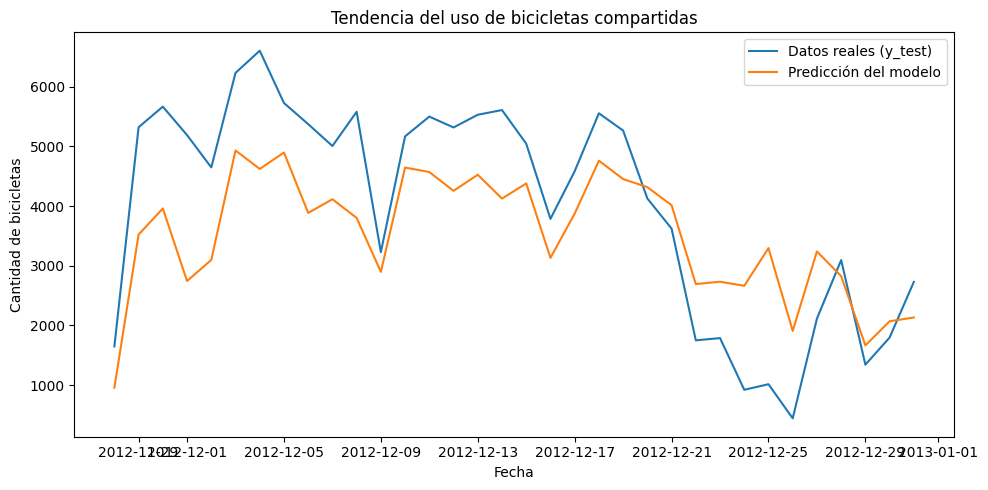

In [31]:
df_daily_test= df_test['cnt'].resample('D').sum()
df_pred = pd.DataFrame(y_pred, index=df_test.index, columns=['cnt'])
df_daily_pred = df_pred['cnt'].resample('D').sum()

plt.figure(figsize=(10,5))
plt.plot(df_daily_test.index, df_daily_test.values, label= 'Datos reales (y_test)')
plt.plot(df_daily_pred.index, df_daily_pred.values, label= 'Predicción del modelo')
plt.title('Tendencia del uso de bicicletas compartidas')
plt.xlabel('Fecha')
plt.ylabel('Cantidad de bicicletas')
plt.legend()
plt.tight_layout()
plt.show()

In [32]:
#Step 5. Model Saving
artifact = {
    "name":"Prediction model for Bike Sharing",
    "author":"Adrian Chirinos y Eduardo Buysse",
    "model":model,
    "predictors":X_train.columns.to_list(),
    "target_name":y_train.name,
    "version":"1.0",
    "algorithm_name":"Random Forest Regressor"
}

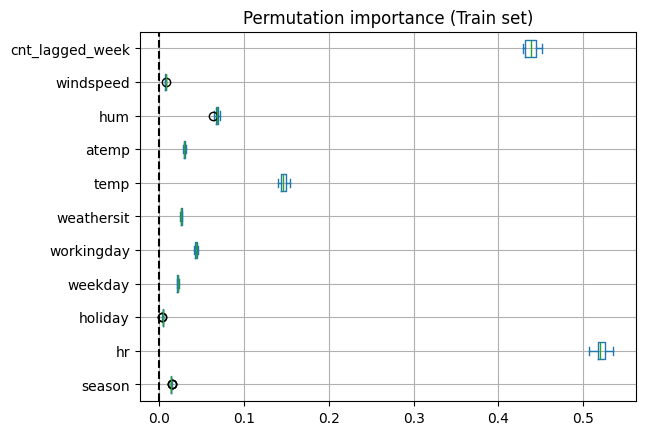

In [35]:
importance = permutation_importance(model, X_train, y_train, n_repeats=25, random_state=2025)
importance_df = pd.DataFrame(importance.importances.T, columns=X_train.columns)

ax = importance_df.plot.box(vert=False)
ax.axvline(x=0, color='k', linestyle='--')
ax.set_title("Permutation importance (Train set)")
ax.grid(True)
plt.show()

In [33]:
with open("../models/bike_sharing.pkl", "wb") as file:
    pickle.dump(artifact, file)